<a href="https://colab.research.google.com/github/kurthorvath/EmergencyVehicleYoloY4/blob/main/YOLOv4_EmergencyVehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Open In Colab](https://colab.research.google.com/github/ibaiGorordo/Social-Distance-Feedback/blob/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/YOLOv4_tiny_Darknet_Mask_Detection.ipynb)

# DepthAI Tutorial: Training a Tiny YOLOv4 Object Detector with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

Welcome to DepthAI!

In this tutorial we will train an object detector using the Tiny Yolo v4 model. This model will run on our DepthAI Myriad X modules.

The model is pretrained on the COCO dataset. The framework used for training is Darknet.
Will run through the following steps:


*   Install the libraries (Darknet , etc.)
*   Clone the github repo and replace the repo training data with your data (from google drive or from own repo - which is faster)
*   Train the model on the new images
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: the model training can be run with the repo images of medical masks if you choose to skip the customization part for your own images just to see how the training and the rest of the steps work

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e2419f2f-0f86-7e70-623b-466a1c2a6f22)


# Installing Darknet for YOLOv4 on Colab




In [ ]:
%cd /content/
%rm -rf darknet

/content


In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15851, done.
remote: Total 15851 (delta 0), reused 0 (delta 0), pack-reused 15851
Receiving objects: 100% (15851/15851), 14.37 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (10683/10683), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


**IMPORTANT! If you're not using a K80 GPU, then uncomment the sed command and replace the arch and code with that matching your GPU. A list can be found [here](http://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/).**

In [ ]:
#install environment from the Makefile
#%cd darknet/
# compute_30, sm_30 for Tesla K80
# compute_75, sm_75 for Tesla T4
# !sed -i 's/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_30,code=sm_30/g' Makefile

#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!make

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: wa

## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint.
Changes to some files need to be made according to own data, but it is nothing complicated.

In [ ]:
repo_url = 'https://github.com/kurthorvath/yolotinyv3_emergencyVehicle'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'yolotinyv3_emergencyVehicle'...
remote: Enumerating objects: 2404, done.
remote: Counting objects: 100% (2402/2402), done.
remote: Compressing objects: 100% (1858/1858), done.
remote: Total 2404 (delta 143), reused 2396 (delta 137), pack-reused 2
Receiving objects: 100% (2404/2404), 359.13 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/yolotinyv3_emergencyVehicle


In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

## Change the labels in obj.names to our current labels

In [ ]:
!cat /content/yolotinyv3_emergencyVehicle/obj.names

car
emergencyvehicle


In [ ]:
repo_url = 'https://github.com/kurthorvath/yolotinyv3_emergencyVehicle'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
fatal: destination path 'yolotinyv3_emergencyVehicle' already exists and is not an empty directory.
/content/yolotinyv3_emergencyVehicle


## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [ ]:
import re
objdata = '/content/yolotinyv3_emergencyVehicle/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = 2 #len(labels)
#s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

#with open(objdata, 'w') as f:
#  f.write(s)
!cat /content/yolotinyv3_emergencyVehicle/obj.data

classes = 2
train = /content/yolotinyv3_emergencyVehicle/train.txt
names = /content/yolotinyv3_emergencyVehicle/obj.names
backup = backup/


### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size
# that are both is inside the model structure

num_classes = 2
num_filters = (num_classes + 5) * 3

cfg_file = '/content/yolotinyv3_emergencyVehicle/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)


## Start the model training

In [ ]:
%cd ../darknet/
import os

print("Path at terminal when executing this file")
print(os.getcwd() + "\n")
!./darknet detector train ../yolotinyv3_emergencyVehicle/obj.data /content/yolotinyv3_emergencyVehicle/yolov4-tiny.cfg /content/yolotinyv3_emergencyVehicle/yolov4-tiny.conv.29 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
 Last accuracy mAP@0.50 = 100.00 %, best = 100.00 % 3514/4000: loss=0.0 map=1.00 best=1.00 hours left=0.2
 3514: 0.006805, 0.017292 avg loss, 0.000261 rate, 0.911385 seconds, 224896 images, 0.175933 hours left
Loaded: 0.099809 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.919113), count: 75, class_loss = 0.051351, iou_loss = 0.924572, total_loss = 0.975923 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.936910), count: 135, class_loss = 0.020742, iou_loss = 6.916238, total_loss = 6.936979 
 total_bbox = 812375, rewritten_bbox = 0.000000 % 

 (next mAP calculation at 3600 iterations) 

 Tensor Cores are used.
 Last accuracy mAP@0.50 = 100.00 %, best = 100.00 % 3515/4000: loss=0.0 map=1.00 best=1.00 hours left=0.2
 3515: 0.036125, 0.019175 avg loss, 0.000261 rate, 0.681077 seconds, 224960 images, 0.175728 hours left
Loaded: 0.109814 seconds - performance bot

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

!cp -av '/gdrive/My Drive/backupColab/content/' '../content/'

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

!cp -av '/content' '/gdrive/My Drive/backupColab'

In [ ]:
imShow("chart_yolov4-tiny.png")

## Check the model performance
The metrics run on the test images so they may not be fully representative, only indicative

In [ ]:
!rsync -avH /content/darknet/ /content/darknet

In [ ]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

## Run detection on an image. I choose one of the test images from test.txt

/content/darknet
Path at terminal when executing this file
/content/darknet

-rwxrwxrwx 1 root root 6157632 Aug  8 09:29 /content/darknet/darknet
 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	    

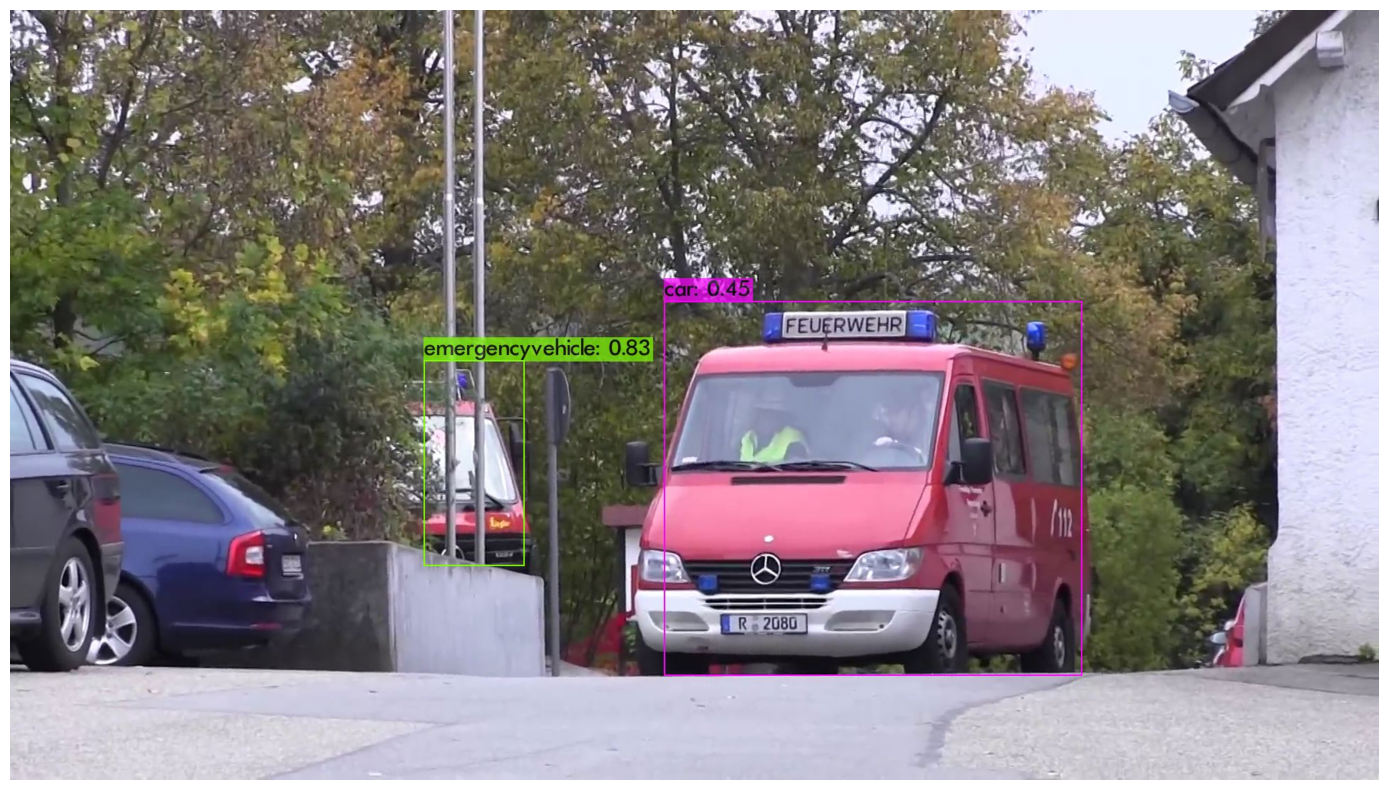

In [ ]:
import os
%cd /content/darknet

print("Path at terminal when executing this file")
print(os.getcwd() + "\n")
!chmod 777 /content/darknet/darknet
!chmod 660 /content/yolotinyv3_emergencyVehicle/obj.data
!ls -la /content/darknet/darknet
!./darknet detector test /content/yolotinyv3_emergencyVehicle/obj.data  /content/yolotinyv3_emergencyVehicle/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/yolotinyv3_emergencyVehicle/obj/testdata/7.png -ext_output
imShow('predictions.jpg')

In [ ]:
repo_url = 'https://github.com/kurthorvath/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


# Step 7: Running YOLOv4 on Video in the Cloud!

You can also run YOLOv4 object detections on video in your Google Colab VM. Follow the cells below to see how to run videos from your local machine or from your Google Drive!

## Local Machine Video
Here is how to upload video from local machine, run detector and then download video showing detections.

In [ ]:
#!wget -O test.mp4 "https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4"

In [ ]:
!./darknet detector demo /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" -dont_show /content/yolotinyv3_medmask_demo/obj/testdata/battlefield120_4.mp4 -i 0 -out_filename bf.mp4

In [ ]:
# download the video with detections shown
from google.colab import files

video_path = 'vid34out.mp4'
files.download(video_path)